# FDTD vs Spectral Methods (2D Transverse / 3D Simulation)

This notebook compares the **3D Finite-Difference Time-Domain (FDTD)** solution for the Relativistic Schrödinger Equation against standard Spectral Propagation methods:
1. **Fresnel Propagation**
2. **Angular Spectrum Method**
3. **Wave Propagation Method (WPM)**

We compare propagation of a **2D Wavefront** through a **3D Potential** (Single Atom).
_Note: Resolution is reduced compared to the 1D benchmark to keep runtime reasonable._

In [44]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import jax
import abtem
import ase
import jax.numpy as jnp
from ase.units import  _hplanck, _c, _me, _e

from wide_angle_propagation import (
    simulate_fresnel_as,
    simulate_wpm,
    fresnel_propagation_kernel,
    angular_spectrum_propagation_kernel
)
from wide_angle_propagation import RelativisticSolver3D, calculate_physics_params

# Configure JAX
jax.config.update("jax_enable_x64", True)


## 1. Simulation Setup (3D)

**Physics:**
- Wavelength $\lambda = 0.05$ Å (Lower energy for stronger scattering)
- Potential: Single Au Atom

Grid Summary:
  ROI:  64x64x64
  FDTD: 64x64x94
  Steps: dx=0.0317, dz=0.0317


Text(0.5, 1.0, 'Potential Slice (XZ)')

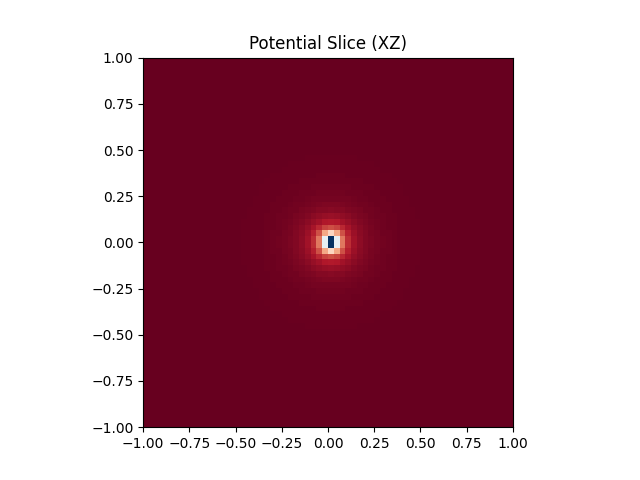

In [45]:

def wavelength_to_energy_ev(lam_angstrom):
    lam = lam_angstrom * 1e-10
    h = _hplanck
    c = _c
    m = _me
    p = h / lam
    E_total_J = np.sqrt((p*c)**2 + (m*c**2)**2)
    E_kin_J = E_total_J - (m*c**2)
    return E_kin_J / _e

# Match 1D baseline for easier comparison
wavelength_angstrom = 0.025
e_total, p_inf, e_sim = calculate_physics_params(wavelength_angstrom)
k0 = p_inf
energy_ev = wavelength_to_energy_ev(wavelength_angstrom)

# --- 2. Grid Setup ---
# Reduced resolution for 3D demonstration
nx, ny = 64, 64
roi_nz = 64

roi_xmin, roi_xmax = -1.0, 1.0
roi_ymin, roi_ymax = -1.0, 1.0
roi_zmin, roi_zmax = -1.0, 1.0

x = np.linspace(roi_xmin, roi_xmax, nx)
y = np.linspace(roi_ymin, roi_ymax, ny)
z = np.linspace(roi_zmin, roi_zmax, roi_nz)
dx, dy, dz = x[1]-x[0], y[1]-y[0], z[1]-z[0]

extent_roi = [roi_xmin, roi_xmax, roi_ymin, roi_ymax, roi_zmin, roi_zmax]

# --- 3. Extended Grid for FDTD ---
pml_thickness = 0.3
source_buffer = 0.2
z_pad = pml_thickness + source_buffer

ext_zmin = roi_zmin - z_pad
ext_zmax = roi_zmax + z_pad

ext_nz = int(np.round((ext_zmax - ext_zmin) / dz))
z_ext = np.linspace(ext_zmin, ext_zmin + (ext_nz-1)*dz, ext_nz)
ext_zmax = z_ext[-1]
extent_ext = [roi_xmin, roi_xmax, roi_ymin, roi_ymax, ext_zmin, ext_zmax]

print("Grid Summary:")
print(f"  ROI:  {nx}x{ny}x{roi_nz}")
print(f"  FDTD: {nx}x{ny}x{ext_nz}")
print(f"  Steps: dx={dx:.4f}, dz={dz:.4f}")

# --- 4. Potential Generation (3D) ---
# Use abtem-based potential (same approach as single_atom.ipynb).

# match single_atom defaults for determinism
abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})

# Create a single Au atom centered in a cell that matches ROI extents
cell_x = roi_xmax - roi_xmin
cell_y = roi_ymax - roi_ymin
cell_z = roi_nz * dz
atoms = ase.Atoms('Au', cell=[cell_x, cell_y, cell_z], pbc=True)
atoms.center()

# Build potential with slice_thickness matching dz and 2D gpts (abtem expects 2D grid)
pot = abtem.Potential(atoms, gpts=(nx, ny), slice_thickness=dz, projection='finite')
pot_arr = pot.build(lazy=False).array

plt.figure()
plt.imshow(pot_arr[:, ny//2, :], extent=[roi_xmin, roi_xmax, roi_zmin, roi_zmax], origin='lower', cmap='RdBu')
plt.title("Potential Slice (XZ)")

Inserted ROI potential into ext grid at z indices [16, 80) of 94


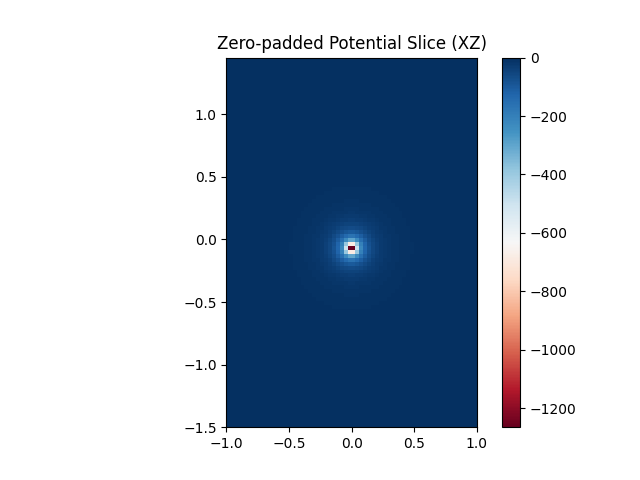

In [46]:

v_phys_roi_t = pot_arr.transpose(2, 1, 0)

# Create zero-padded extended potential and insert ROI potential at correct z indices
v_eff_fdtd_t = np.zeros((ext_nz, ny, nx), dtype=np.float64)

# find index in extended z-grid corresponding to ROI z_min (best match)
k0 = int(np.argmin(np.abs(z_ext - roi_zmin)))

# ensure ROI fits; shift if necessary
if k0 + roi_nz > ext_nz:
    k0 = ext_nz - roi_nz

v_eff_fdtd_t[k0 : k0 + roi_nz, :, :] = -v_phys_roi_t

print(f"Inserted ROI potential into ext grid at z indices [{k0}, {k0+roi_nz}) of {ext_nz}")
plt.figure()
plt.imshow(v_eff_fdtd_t[:, ny//2, :], extent=[roi_xmin, roi_xmax, ext_zmin, ext_zmax], origin='upper', cmap='RdBu')
plt.title("Zero-padded Potential Slice (XZ)")
plt.colorbar()
plt.show()


## 2. Run 3D FDTD Simulation

Source k: 12 (z approx -1.12 Å)
Running FDTD with Direct Angstrom/eV Units...
Configuration changed. Updating fdtd_3d.cu...
Compiling CUDA solver...
Compilation successful: fdtd_3d_bin
Running 3D: fdtd_3d_bin 200 200 50 -0.025
Loaded 50 snapshots.
Normalized FDTD by incident intensity: 1.213210e-03


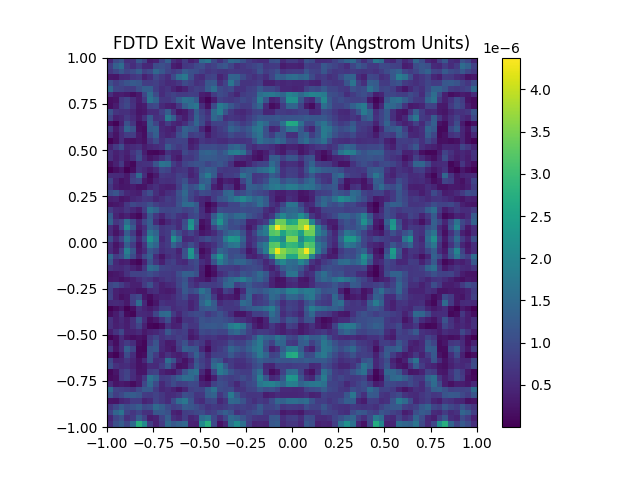

In [47]:
def run_fdtd_3d():
    solver = RelativisticSolver3D()

    # --- Unit Handling ---
    # With the updated solver code, we can now pass Angstrom-eV units directly.
    # The solver will compile a custom kernel with the correct physics constants.
    
    # 1. Grid Extent (Angstroms)
    extent_angstroms = extent_ext # (xmin, xmax, ymin, ymax, zmin, zmax)

    # 2. Potential (eV)
    # v_eff_fdtd_t is "Projected Potential" [eV * A] from abtem accumulation.
    # We convert to "Potential Energy" [eV] by dividing by slice thickness.
    v_fdtd_ev = (v_eff_fdtd_t / dz)
    # (Note: abtem potential is V(r). Hamiltonian uses e*V(r). In eV, these are same number.)

    # 3. PML Thickness (Angstroms)
    pml_thickness_ang = pml_thickness

    # Source Position (k index) 
    dist_src = pml_thickness + source_buffer * 0.5
    k_source = int(dist_src / dz)

    print(f"Source k: {k_source} (z approx {ext_zmin + k_source*dz:.2f} Å)")
    print(f"Running FDTD with Direct Angstrom/eV Units...")

    sim_result = solver.run(
        v_fdtd_ev,
        wavelength_angstrom=wavelength_angstrom, 
        extent=extent_angstroms,
        n_frames=200, # Increase for steady state
        steps_per_frame=200, 
        snapshot_count=50, # Keep more frames for averaging
        pml_thick=pml_thickness_ang,
        k_source=k_source,
        use_angstrom_units=True  # New flag to trigger unit-aware compilation
    )

    if not sim_result:
        raise RuntimeError("FDTD Failed")

    return sim_result

fdtd_res = run_fdtd_3d()

# Extract Exit Wave (at end of ROI)
k_exit = np.argmin(np.abs(z_ext - roi_zmax))
k_entry = np.argmin(np.abs(z_ext - roi_zmin))
k_monitor = max(0, k_entry - 2)

# Integrate Steady State at Exit Plane
snapshots = fdtd_res['snapshots']
E_sim = fdtd_res['E_sim']

psi_exit_accum = np.zeros((ny, nx), dtype=np.complex128)
psi_monitor_accum = np.zeros((ny, nx), dtype=np.complex128)
count = 0

# Average last 40% of frames
start_avg = int(0.6 * len(snapshots))
for t, phi, psi in snapshots[start_avg:]:
    # Phasor rotation to demodulate
    # Note: t here is in internal solver time units.
    # With use_angstrom_units=True, t is roughly hbar/eV units.
    # E_sim is roughly eV (but potentially scaled for numerical stability).
    # The product E_sim*t should be the correct phase.
    phasor = np.exp(1j * E_sim * t)
    field3d = (phi + 1j * psi) * phasor
    psi_exit_accum += field3d[k_exit, :, :]
    psi_monitor_accum += field3d[k_monitor, :, :]
    count += 1

psi_fdtd_exit = psi_exit_accum / count
psi_monitor = psi_monitor_accum / count

# Normalize by incident intensity measured before ROI
I_incident = np.mean(np.abs(psi_monitor)**2)
if I_incident > 1e-9:
    psi_fdtd_exit = psi_fdtd_exit / np.sqrt(I_incident)
    print(f"Normalized FDTD by incident intensity: {I_incident:.6e}")

plt.figure()
plt.imshow(np.abs(psi_fdtd_exit)**2, extent=[roi_xmin, roi_xmax, roi_ymin, roi_ymax], origin='lower')
plt.title("FDTD Exit Wave Intensity (Angstrom Units)")
plt.colorbar()
plt.show()

## 3. Spectral Methods (BPM)

Propagating a 2D plane wave through the 3D potential slice-by-slice.

In [48]:
# Initial wave: plane wave (all ones)
psi_init = jnp.ones((ny, nx), dtype=jnp.complex128)

# Calculate potential in eV for BPM (abtem yields potential energy in eV)
v_bpm_eV = np.array(v_phys_roi_t, dtype=np.float64)
# Divide by slice thickness to match per-slice potential used by spectral methods (as in single_atom.ipynb)
v_bpm_eV = v_bpm_eV / dz
v_bpm_eV_jax = jnp.array(v_bpm_eV)

# Sampling for kernels (y, x)
sampling = (dy, dx)

print("Starting spectral simulations (using energy in eV)...")

# --- Pre-propagate through vacuum to match FDTD padding ---
vacuum_dist = z_pad
prop_kernel_vac = angular_spectrum_propagation_kernel(ny, nx, sampling, vacuum_dist, energy_ev)
psi_init = jnp.fft.ifft2(jnp.fft.fft2(psi_init) * prop_kernel_vac)

# --- 1. Fresnel ---
prop_kernel_fresnel = fresnel_propagation_kernel(ny, nx, sampling, dz, energy_ev)
psi_fresnel, _, psi_fresnel_xyz = simulate_fresnel_as(v_bpm_eV_jax, psi_init, prop_kernel_fresnel, dz, energy_ev)

# --- 2. Angular Spectrum ---
prop_kernel_as = angular_spectrum_propagation_kernel(ny, nx, sampling, dz, energy_ev)
psi_as, _, psi_as_xyz = simulate_fresnel_as(v_bpm_eV_jax, psi_init, prop_kernel_as, dz, energy_ev)

# --- 3. WPM ---
psi_wpm, _, psi_wpm_xyz = simulate_wpm(v_bpm_eV_jax, psi_init, dz, energy_ev, sampling, n_bins=32)

print("Spectral simulations complete.")

Starting spectral simulations (using energy in eV)...
Spectral simulations complete.


## 4. Comparison

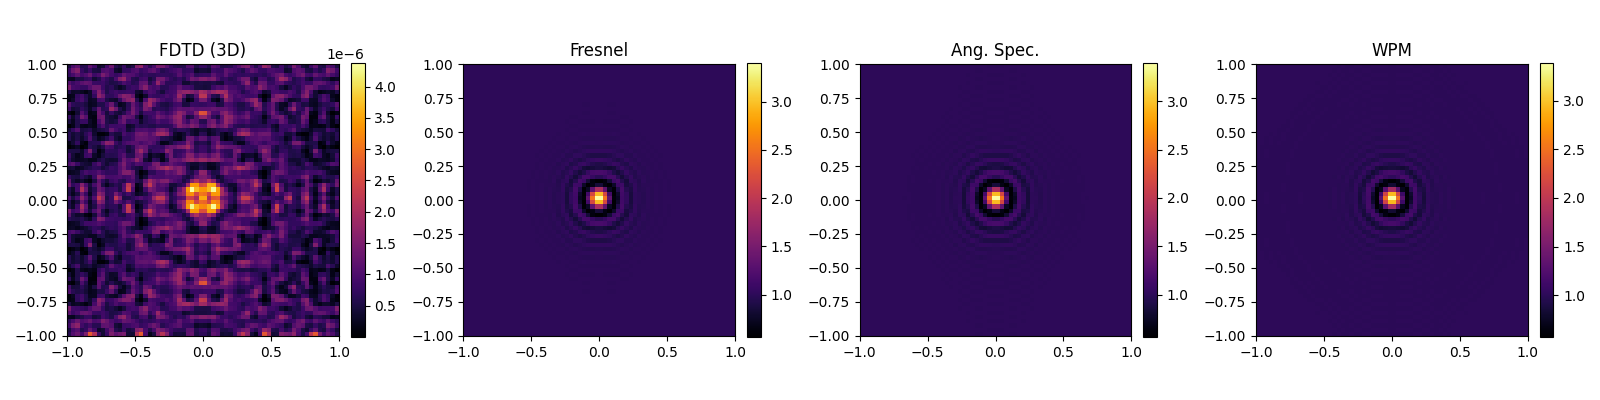

In [49]:
# Normalize FDTD to match mean intensity of others (approx)
# (FDTD has temporal envelope scaling)
scale = 1
psi_fdtd_scaled = psi_fdtd_exit * scale

methods = [
    (np.abs(psi_fdtd_scaled)**2, "FDTD (3D)"),
    (np.abs(psi_fresnel)**2, "Fresnel"),
    (np.abs(psi_as)**2, "Ang. Spec."),
    (np.abs(psi_wpm)**2, "WPM")
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, (data, title) in zip(axes, methods):
    im = ax.imshow(data, extent=[roi_xmin, roi_xmax, roi_ymin, roi_ymax], 
                   origin='lower', cmap='inferno')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

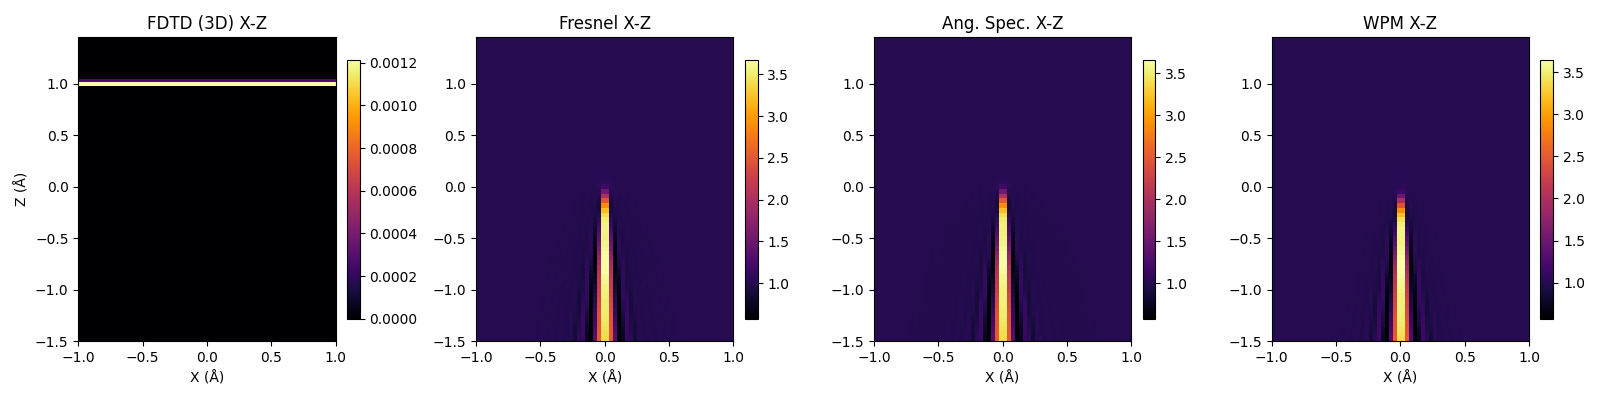

In [50]:
# X-Z view (central Y slice)
central_y = ny // 2

# Build FDTD X-Z from snapshots (average last 40%)
start_avg = int(0.6 * len(snapshots))
psi_fdtd_xz_accum = np.zeros((len(z_ext), nx), dtype=np.complex128)
count = 0
for t, phi, psi in snapshots[start_avg:]:
    phasor = np.exp(1j * E_sim * t)
    field3d = (phi + 1j * psi) * phasor  # shape (Z_ext, Y, X)
    psi_fdtd_xz_accum += field3d[:, central_y, :]
    count += 1
psi_fdtd_xz = psi_fdtd_xz_accum / count
psi_fdtd_xz_scaled = psi_fdtd_xz * scale

# Spectral methods: use central Y slice and tile across Z for X-Z display
psi_fresnel_np = np.array(psi_fresnel)
psi_as_np = np.array(psi_as)
psi_wpm_np = np.array(psi_wpm)

psi_fresnel_x = psi_fresnel_np[central_y, :]
psi_as_x = psi_as_np[central_y, :]
psi_wpm_x = psi_wpm_np[central_y, :]

# Ensure images are real floats (use intensity = |psi|^2)
psi_fresnel_xz = (np.abs(np.array(psi_fresnel_xyz)[:, central_y, :])**2).astype(np.float64)
psi_as_xz      = (np.abs(np.array(psi_as_xyz)[:, central_y, :])**2).astype(np.float64)
psi_wpm_xz     = (np.abs(np.array(psi_wpm_xyz)[:, central_y, :])**2).astype(np.float64)

psi_fdtd_xz_im = np.abs(psi_fdtd_xz_scaled)**2
# Plot X (horizontal) vs Z (vertical)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

extent_xz = [x[0], x[-1], z_ext[0], z_ext[-1]]

im0 = axes[0].imshow(psi_fdtd_xz_im, extent=extent_xz, origin='upper', aspect='auto', cmap='inferno')
axes[0].set_title("FDTD (3D) X-Z")
axes[0].set_xlabel("X (Å)")
axes[0].set_ylabel("Z (Å)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(psi_fresnel_xz, extent=extent_xz, origin='upper', aspect='auto', cmap='inferno')
axes[1].set_title("Fresnel X-Z")
axes[1].set_xlabel("X (Å)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(psi_as_xz, extent=extent_xz, origin='upper', aspect='auto', cmap='inferno')
axes[2].set_title("Ang. Spec. X-Z")
axes[2].set_xlabel("X (Å)")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

im3 = axes[3].imshow(psi_wpm_xz, extent=extent_xz, origin='upper', aspect='auto', cmap='inferno')
axes[3].set_title("WPM X-Z")
axes[3].set_xlabel("X (Å)")
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
